# Quantitative analysis - Module adjacency and architecture

In [1]:
import csv
from itertools import chain, product
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mysql.connector
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sb

user = 'xxxx' # fill in MySQL user
password = 'xxxx' # fill in MySQL pw
db = 'xxxx' # fill in MySQL database name
socket = '/x/x/x/x.sock' # fill in MySQL unix socket

## Data

### Wrangle accessions

In [2]:
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
cursor = cnx.cursor()
cursor.execute("SELECT DISTINCT(UniProt_ID), type, type_evidence, type_probability FROM UniProt;")

up_acc = []
types = []
type_evidence = []
type_probability = []
for i in cursor:
    up_acc.append(i[0])
    types.append(i[1])
    type_evidence.append(i[2])
    type_probability.append(i[3])
tmp = {'type' : types, 'type_evidence' : type_evidence, 'type_probability' : type_probability}
main_table = pd.DataFrame(tmp, index=up_acc)
#main_table

In [3]:
### set confidence level threshold for protein typing
endolysins = [i for i in main_table.index if main_table.loc[i, 'type'] == 'endolysin' and main_table.loc[i, 'type_probability'] >= 75]
vals = [i for i in main_table.index if main_table.loc[i, 'type'] == 'VAL' and main_table.loc[i, 'type_probability'] >= 75]
unclass = [i for i in main_table.index if i not in endolysins and i not in vals]

Endolysins and VALs used for analyses will consist of the proteins that have been called as such with a certainty of at least 75%.

In [4]:
### VAL vs endolysin sequences
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)

cursor = cnx.cursor()
cursor.execute("SELECT ur.protein_sequence, up.UniProt_ID FROM UniProt as up JOIN UniRef as ur WHERE up.UniRef_ID = ur.UniRef_ID;")

endolysin_seqs = []
val_seqs = []
acc2seq = {}
for i in cursor:
    if i[1] in endolysins:
        endolysin_seqs.append(i[0])
    elif i[1] in vals:
        val_seqs.append(i[0])
    acc2seq[i[1]] = i[0]
        
### unique sequences
unique_seq_accs = []
unique_seqs = []
for k, v in acc2seq.items():
    if v not in unique_seqs:
        unique_seqs.append(v)
        unique_seq_accs.append(k)

### Wrangle domains

In [5]:
domains = pd.read_csv("domains/custom_domain_clusters.csv", sep=',', index_col="accession", 
                      usecols=['accession', 'abbreviation', 'class', 'sub'])

In [6]:
cbds = []
pgas = []
pgaps = []
pgps = []
pggs = []
pgms = []
pgmts = []
pglts = []
misc = []
sorted_doms = []
for i in domains.index:
    if domains.loc[i]['class'] == 'CBD' and domains.loc[i]['abbreviation'] not in sorted_doms:
        cbds.append(domains.loc[i]['abbreviation'])
        sorted_doms.append(domains.loc[i]['abbreviation'])
    elif domains.loc[i]['class'] == 'EAD' and domains.loc[i]['abbreviation'] not in sorted_doms:
        if domains.loc[i]['sub'] == 'A':
            pgas.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'A+P':
            pgaps.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'P':
            pgps.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'G':
            pggs.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'M':
            pgms.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'M+T':
            pgmts.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
        elif domains.loc[i]['sub'] == 'T':
            pglts.append(domains.loc[i]['abbreviation'])
            sorted_doms.append(domains.loc[i]['abbreviation'])
    elif domains.loc[i]['class'] == 'MISC' and domains.loc[i]['abbreviation'] not in sorted_doms:
        misc.append(domains.loc[i]['abbreviation'])
        sorted_doms.append(domains.loc[i]['abbreviation'])

amidases = pgas + pgaps
peptidases = pgaps + pgps 
muramidases = pgms + pgmts
lts = pgmts + pglts 
eads = pgas + pgaps + pgps + pggs + pgms + pgmts + pglts

In [7]:
### Load in architectures
domains_per_entry = {}
with open('simplified_architectures_condensed.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        domains_per_entry[row[0]] = [i for idx, i in enumerate(row) if idx != 0 and i != '']

### Wrangle bacterial hosts

In [8]:
### get annotation
cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
cursor = cnx.cursor()
cursor.execute("SELECT DISTINCT lineage_phylum, lineage_class, lineage_order, lineage_family, lineage_genus FROM hosts;")

host = pd.DataFrame(index=np.arange(0, 1000), columns=["Phylum", "Class", "Order", "Family", "Genus"])
for idx, i in enumerate(cursor):
    host.iloc[idx]["Phylum"] = i[0]
    host.iloc[idx]["Class"] = i[1]
    host.iloc[idx]["Order"] = i[2]
    host.iloc[idx]["Family"] = i[3]
    host.iloc[idx]["Genus"] = i[4]
    
host["Gramtype"] = '~'
to_remove = []
for i in host.index:
    if host.loc[i]['Order'] in ['Synechococcales', 'Nostocales', 'Oscillatoriales', 'Chroococcales']:
        host.loc[i]['Class'] = 'Cyanophyceae' 
    elif host.loc[i]['Genus'] == 'Plesiomonas':
        host.loc[i]['Family'] = 'Enterobacteriaceae'
    elif host.loc[i]['Genus'] == 'Exiguobacterium':
        host.loc[i]['Family'] = 'Bacillaceae'
    elif host.iloc[i]["Family"] == 'Thermoanaerobacterales Family III. Incertae Sedis':
        host.iloc[i]["Family"] = 'Thermoanaerobacterales 3'
    ### remove unknowns
    if all(host.iloc[i].isna()):
        to_remove.append(i)
    elif pd.isna(host.iloc[i]["Genus"]):
        to_remove.append(i)
    ### gram annotation
    if host.loc[i]["Phylum"] in ['Actinobacteria', 'Firmicutes']:
        if host.loc[i]["Family"] != 'Mycobacteriaceae':
            host.loc[i]["Gramtype"] = '+'
    elif host.loc[i]["Phylum"] in ['Proteobacteria', 'Bacteroidetes', 'Cyanobacteria', 
                                   'Spirochaetes', 'Fusobacteria', 'Deinococcus-Thermus']:
        host.loc[i]["Gramtype"] = '-'

host = host.fillna('Unknown')
host = host.drop(to_remove, axis=0)

### sort genera
gpos = host[host.Gramtype == '+'].sort_values(by=['Phylum', 'Class', 'Order', 'Family'])
gneg = host[host.Gramtype == '-'].sort_values(by=['Phylum', 'Class', 'Order', 'Family'])
gamb = host[host.Gramtype == '~'].sort_values(by=['Phylum', 'Class', 'Order', 'Family'])

sorted_genera = list(pd.concat([gpos, gamb, gneg]).Genus)

In [9]:
### Get hosts for each entry
host_per_entry = {}
for i in list(domains_per_entry.keys()):
    host_per_entry[i] = []
    cnx = mysql.connector.connect(user=user, password=password, database=db, unix_socket=socket)
    cursor = cnx.cursor()
    query = "SELECT h.lineage_genus FROM UniProt as up JOIN link_phage_host as l JOIN hosts as h WHERE up.UniProt_ID = '" + i + "' AND up.phages_ID = l.phages_ID AND l.hosts_ID = h.hosts_ID;"
    cursor.execute(query)
    
    tmp = []
    for j in cursor:
        tmp.append(j[0])
    
    host_per_entry[i] = [k for k in set(tmp) if k != None]

#remove none values
filtered = {k: v for k, v in host_per_entry.items() if None not in v and len(v) != 0}
host_per_entry.clear()
host_per_entry.update(filtered)

## Adjacencies in short endolysin architectures

In [10]:
### possible architectures in an endolysin with 3 modules
poss_archs = [['EAD'], ['CBD']]
poss_archs.extend(list(product(('EAD', 'CBD'), ('EAD', 'CBD'))))
poss_archs.extend(list(product(('EAD', 'CBD'), ('EAD', 'CBD'), ('EAD', 'CBD'))))

endolysin_archs = {k:v for k, v in domains_per_entry.items() if k in endolysins}
short_endolysins = {k:v for k, v in endolysin_archs.items() if len(v) <= 3}
long_endolysins = {k:v for k, v in endolysin_archs.items() if len(v) > 3}
print(len(short_endolysins), "out of", len(endolysin_archs), 
      "unique endolysins with known architectures qualify for this analysis.")
print("The following architectures are thus excluded:\n", 
      list(set([tuple(v) for k, v in long_endolysins.items()])))

6904 out of 6907 unique endolysins with known architectures qualify for this analysis.
The following architectures are thus excluded:
 [('DUF1906', 'Ami_2', 'PET_M23', 'DUF4185'), ('Transposase_InsH_N', 'DDE_Tnp_1_6', 'CHAP', 'SH3')]


In [14]:
len([i for i in short_endolysins if i in unique_seq_accs])

4434

In [18]:
### total occurrences
#archs = np.unique([v for v in short_endolysins.values()])
archs = [v for v in short_endolysins.values()]
all_endo_doms = list(chain.from_iterable(archs))

mod_adj_df = pd.DataFrame(index=np.arange(56), 
                          columns=['Arch', 'Relative fraction', 'Type'])
tmp = {k:v for k, v in short_endolysins.items() if k in host_per_entry}
unique_seq_tmp = {k:v for k, v in tmp.items() if k in unique_seq_accs}
#tot_archs = [v for v in unique_seq_tmp.values()]
#tot_archs = np.unique([v for v in tmp.values()])
tot_archs = [v for v in tmp.values()]

tot_1 = [i for i in tot_archs if len(i) == 1]
mod_adj_df.loc[0, 'Arch'] = "EAD"
mod_adj_df.loc[0, 'Relative fraction'] = len([i for i in tot_1 if i[0] in eads])/len(tot_archs)
mod_adj_df.loc[0, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[1, 'Arch'] = "CBD"
mod_adj_df.loc[1, 'Relative fraction'] = len([i for i in tot_1 if i[0] in cbds])/len(tot_archs)
mod_adj_df.loc[1, 'Type'] = 'Observed in all endolysins' 

tot_2 = [i for i in tot_archs if len(i) == 2]
mod_adj_df.loc[2, 'Arch'] = "EAD-EAD"
mod_adj_df.loc[2, 'Relative fraction'] = len([i for i in tot_2 if i[0] in eads and i[1] in eads])/len(tot_archs)
mod_adj_df.loc[2, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[3, 'Arch'] = "EAD-CBD"
mod_adj_df.loc[3, 'Relative fraction'] = len([i for i in tot_2 if i[0] in eads and i[1] in cbds])/len(tot_archs)
mod_adj_df.loc[3, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[4, 'Arch'] = "CBD-EAD"
mod_adj_df.loc[4, 'Relative fraction'] = len([i for i in tot_2 if i[0] in cbds and i[1] in eads])/len(tot_archs)
mod_adj_df.loc[4, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[5, 'Arch'] = "CBD-CBD"
mod_adj_df.loc[5, 'Relative fraction'] = len([i for i in tot_2 if i[0] in cbds and i[1] in cbds])/len(tot_archs)
mod_adj_df.loc[5, 'Type'] = 'Observed in all endolysins' 

tot_3 = [i for i in tot_archs if len(i) == 3]
mod_adj_df.loc[6, 'Arch'] = "EAD-EAD-EAD"
mod_adj_df.loc[6, 'Relative fraction'] = len([i for i in tot_3 if i[0] in eads and i[1] in eads and i[2] in eads])/len(tot_archs)
mod_adj_df.loc[6, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[7, 'Arch'] = "EAD-EAD-CBD"
mod_adj_df.loc[7, 'Relative fraction'] = len([i for i in tot_3 if i[0] in eads and i[1] in eads and i[2] in cbds])/len(tot_archs)
mod_adj_df.loc[7, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[8, 'Arch'] = "EAD-CBD-CBD"
mod_adj_df.loc[8, 'Relative fraction'] = len([i for i in tot_3 if i[0] in eads and i[1] in cbds and i[2] in cbds])/len(tot_archs)
mod_adj_df.loc[8, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[9, 'Arch'] = "CBD-CBD-CBD"
mod_adj_df.loc[9, 'Relative fraction'] = len([i for i in tot_3 if i[0] in cbds and i[1] in cbds and i[2] in cbds])/len(tot_archs)
mod_adj_df.loc[9, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[10, 'Arch'] = "CBD-CBD-EAD"
mod_adj_df.loc[10, 'Relative fraction'] = len([i for i in tot_3 if i[0] in cbds and i[1] in cbds and i[2] in eads])/len(tot_archs)
mod_adj_df.loc[10, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[11, 'Arch'] = "CBD-EAD-EAD"
mod_adj_df.loc[11, 'Relative fraction'] = len([i for i in tot_3 if i[0] in cbds and i[1] in eads and i[2] in eads])/len(tot_archs)
mod_adj_df.loc[11, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[12, 'Arch'] = "EAD-CBD-EAD"
mod_adj_df.loc[12, 'Relative fraction'] = len([i for i in tot_3 if i[0] in eads and i[1] in cbds and i[2] in eads])/len(tot_archs)
mod_adj_df.loc[12, 'Type'] = 'Observed in all endolysins' 
mod_adj_df.loc[13, 'Arch'] = "CBD-EAD-CBD"
mod_adj_df.loc[13, 'Relative fraction'] = len([i for i in tot_3 if i[0] in cbds and i[1] in eads and i[2] in cbds])/len(tot_archs)
mod_adj_df.loc[13, 'Type'] = 'Observed in all endolysins' 

In [19]:
# G+ occurrences
#G_pos_archs = [v for k, v in unique_seq_tmp.items() if len(set(gpos.Genus).intersection(set(host_per_entry[k]))) > 0]
#G_pos_archs = np.unique([v for k, v in tmp.items() if len(set(gpos.Genus).intersection(set(host_per_entry[k]))) > 0])
G_pos_archs = [v for k, v in tmp.items() if len(set(gpos.Genus).intersection(set(host_per_entry[k]))) > 0]

G_pos_1 = [i for i in G_pos_archs if len(i) == 1]
mod_adj_df.loc[14, 'Arch'] = "EAD"
mod_adj_df.loc[14, 'Relative fraction'] = len([i for i in G_pos_1 if i[0] in eads])/len(G_pos_archs)
mod_adj_df.loc[14, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[15, 'Arch'] = "CBD"
mod_adj_df.loc[15, 'Relative fraction'] = len([i for i in G_pos_1 if i[0] in cbds])/len(G_pos_archs)
mod_adj_df.loc[15, 'Type'] = 'Observed in G+ targeting endolysins' 

G_pos_2 = [i for i in G_pos_archs if len(i) == 2]
mod_adj_df.loc[16, 'Arch'] = "EAD-EAD"
mod_adj_df.loc[16, 'Relative fraction'] = len([i for i in G_pos_2 if i[0] in eads and i[1] in eads])/len(G_pos_archs)
mod_adj_df.loc[16, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[17, 'Arch'] = "EAD-CBD"
mod_adj_df.loc[17, 'Relative fraction'] = len([i for i in G_pos_2 if i[0] in eads and i[1] in cbds])/len(G_pos_archs)
mod_adj_df.loc[17, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[18, 'Arch'] = "CBD-EAD"
mod_adj_df.loc[18, 'Relative fraction'] = len([i for i in G_pos_2 if i[0] in cbds and i[1] in eads])/len(G_pos_archs)
mod_adj_df.loc[18, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[19, 'Arch'] = "CBD-CBD"
mod_adj_df.loc[19, 'Relative fraction'] = len([i for i in G_pos_2 if i[0] in cbds and i[1] in cbds])/len(G_pos_archs)
mod_adj_df.loc[19, 'Type'] = 'Observed in G+ targeting endolysins' 

G_pos_3 = [i for i in G_pos_archs if len(i) == 3]
mod_adj_df.loc[20, 'Arch'] = "EAD-EAD-EAD"
mod_adj_df.loc[20, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in eads and i[1] in eads and i[2] in eads])/len(G_pos_archs)
mod_adj_df.loc[20, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[21, 'Arch'] = "EAD-EAD-CBD"
mod_adj_df.loc[21, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in eads and i[1] in eads and i[2] in cbds])/len(G_pos_archs)
mod_adj_df.loc[21, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[22, 'Arch'] = "EAD-CBD-CBD"
mod_adj_df.loc[22, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in eads and i[1] in cbds and i[2] in cbds])/len(G_pos_archs)
mod_adj_df.loc[22, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[23, 'Arch'] = "CBD-CBD-CBD"
mod_adj_df.loc[23, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in cbds and i[1] in cbds and i[2] in cbds])/len(G_pos_archs)
mod_adj_df.loc[23, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[24, 'Arch'] = "CBD-CBD-EAD"
mod_adj_df.loc[24, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in cbds and i[1] in cbds and i[2] in eads])/len(G_pos_archs)
mod_adj_df.loc[24, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[25, 'Arch'] = "CBD-EAD-EAD"
mod_adj_df.loc[25, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in cbds and i[1] in eads and i[2] in eads])/len(G_pos_archs)
mod_adj_df.loc[25, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[26, 'Arch'] = "EAD-CBD-EAD"
mod_adj_df.loc[26, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in eads and i[1] in cbds and i[2] in eads])/len(G_pos_archs)
mod_adj_df.loc[26, 'Type'] = 'Observed in G+ targeting endolysins' 
mod_adj_df.loc[27, 'Arch'] = "CBD-EAD-CBD"
mod_adj_df.loc[27, 'Relative fraction'] = len([i for i in G_pos_3 if i[0] in cbds and i[1] in eads and i[2] in cbds])/len(G_pos_archs)
mod_adj_df.loc[27, 'Type'] = 'Observed in G+ targeting endolysins' 

In [20]:
# G- occurrences
#G_neg_archs = [v for k, v in unique_seq_tmp.items() if len(set(gneg.Genus).intersection(set(host_per_entry[k]))) > 0]
#G_neg_archs = np.unique([v for k, v in tmp.items() if len(set(gneg.Genus).intersection(set(host_per_entry[k]))) > 0])
G_neg_archs = [v for k, v in tmp.items() if len(set(gneg.Genus).intersection(set(host_per_entry[k]))) > 0]

G_neg_1 = [i for i in G_neg_archs if len(i) == 1]
mod_adj_df.loc[28, 'Arch'] = "EAD"
mod_adj_df.loc[28, 'Relative fraction'] = len([i for i in G_neg_1 if i[0] in eads])/len(G_neg_archs)
mod_adj_df.loc[28, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[29, 'Arch'] = "CBD"
mod_adj_df.loc[29, 'Relative fraction'] = len([i for i in G_neg_1 if i[0] in cbds])/len(G_neg_archs)
mod_adj_df.loc[29, 'Type'] = 'Observed in G- targeting endolysins' 

G_neg_2 = [i for i in G_neg_archs if len(i) == 2]
mod_adj_df.loc[30, 'Arch'] = "EAD-EAD"
mod_adj_df.loc[30, 'Relative fraction'] = len([i for i in G_neg_2 if i[0] in eads and i[1] in eads])/len(G_neg_archs)
mod_adj_df.loc[30, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[31, 'Arch'] = "EAD-CBD"
mod_adj_df.loc[31, 'Relative fraction'] = len([i for i in G_neg_2 if i[0] in eads and i[1] in cbds])/len(G_neg_archs)
mod_adj_df.loc[31, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[32, 'Arch'] = "CBD-EAD"
mod_adj_df.loc[32, 'Relative fraction'] = len([i for i in G_neg_2 if i[0] in cbds and i[1] in eads])/len(G_neg_archs)
mod_adj_df.loc[32, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[33, 'Arch'] = "CBD-CBD"
mod_adj_df.loc[33, 'Relative fraction'] = len([i for i in G_neg_2 if i[0] in cbds and i[1] in cbds])/len(G_neg_archs)
mod_adj_df.loc[33, 'Type'] = 'Observed in G- targeting endolysins' 

G_neg_3 = [i for i in G_neg_archs if len(i) == 3]
mod_adj_df.loc[34, 'Arch'] = "EAD-EAD-EAD"
mod_adj_df.loc[34, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in eads and i[1] in eads and i[2] in eads])/len(G_neg_archs)
mod_adj_df.loc[34, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[35, 'Arch'] = "EAD-EAD-CBD"
mod_adj_df.loc[35, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in eads and i[1] in eads and i[2] in cbds])/len(G_neg_archs)
mod_adj_df.loc[35, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[36, 'Arch'] = "EAD-CBD-CBD"
mod_adj_df.loc[36, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in eads and i[1] in cbds and i[2] in cbds])/len(G_neg_archs)
mod_adj_df.loc[36, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[37, 'Arch'] = "CBD-CBD-CBD"
mod_adj_df.loc[37, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in cbds and i[1] in cbds and i[2] in cbds])/len(G_neg_archs)
mod_adj_df.loc[37, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[38, 'Arch'] = "CBD-CBD-EAD"
mod_adj_df.loc[38, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in cbds and i[1] in cbds and i[2] in eads])/len(G_neg_archs)
mod_adj_df.loc[38, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[39, 'Arch'] = "CBD-EAD-EAD"
mod_adj_df.loc[39, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in cbds and i[1] in eads and i[2] in eads])/len(G_neg_archs)
mod_adj_df.loc[39, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[40, 'Arch'] = "EAD-CBD-EAD"
mod_adj_df.loc[40, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in eads and i[1] in cbds and i[2] in eads])/len(G_neg_archs)
mod_adj_df.loc[40, 'Type'] = 'Observed in G- targeting endolysins' 
mod_adj_df.loc[41, 'Arch'] = "CBD-EAD-CBD"
mod_adj_df.loc[41, 'Relative fraction'] = len([i for i in G_neg_3 if i[0] in cbds and i[1] in eads and i[2] in cbds])/len(G_neg_archs)
mod_adj_df.loc[41, 'Type'] = 'Observed in G- targeting endolysins' 

In [21]:
gamb.Genus

15        Mycobacterium
32      Mycobacteroides
88    Mycolicibacterium
Name: Genus, dtype: object

In [15]:
# G~ occurrences
#G_amb_archs = [v for k, v in unique_seq_tmp.items() if len(set(gamb.Genus).intersection(set(host_per_entry[k]))) > 0]
#G_amb_archs = np.unique([v for k, v in tmp.items() if len(set(gamb.Genus).intersection(set(host_per_entry[k]))) > 0])
G_amb_archs = [v for k, v in tmp.items() if len(set(gamb.Genus).intersection(set(host_per_entry[k]))) > 0]

G_amb_1 = [i for i in G_amb_archs if len(i) == 1]
mod_adj_df.loc[42, 'Arch'] = "EAD"
mod_adj_df.loc[42, 'Relative fraction'] = len([i for i in G_amb_1 if i[0] in eads])/len(G_amb_archs)
mod_adj_df.loc[42, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[43, 'Arch'] = "CBD"
mod_adj_df.loc[43, 'Relative fraction'] = len([i for i in G_amb_1 if i[0] in cbds])/len(G_amb_archs)
mod_adj_df.loc[43, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 

G_amb_2 = [i for i in G_amb_archs if len(i) == 2]
mod_adj_df.loc[44, 'Arch'] = "EAD-EAD"
mod_adj_df.loc[44, 'Relative fraction'] = len([i for i in G_amb_2 if i[0] in eads and i[1] in eads])/len(G_amb_archs)
mod_adj_df.loc[44, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[45, 'Arch'] = "EAD-CBD"
mod_adj_df.loc[45, 'Relative fraction'] = len([i for i in G_amb_2 if i[0] in eads and i[1] in cbds])/len(G_amb_archs)
mod_adj_df.loc[45, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[46, 'Arch'] = "CBD-EAD"
mod_adj_df.loc[46, 'Relative fraction'] = len([i for i in G_amb_2 if i[0] in cbds and i[1] in eads])/len(G_amb_archs)
mod_adj_df.loc[46, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[47, 'Arch'] = "CBD-CBD"
mod_adj_df.loc[47, 'Relative fraction'] = len([i for i in G_amb_2 if i[0] in cbds and i[1] in cbds])/len(G_amb_archs)
mod_adj_df.loc[47, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 

G_amb_3 = [i for i in G_amb_archs if len(i) == 3]
mod_adj_df.loc[48, 'Arch'] = "EAD-EAD-EAD"
mod_adj_df.loc[48, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in eads and i[1] in eads and i[2] in eads])/len(G_amb_archs)
mod_adj_df.loc[48, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[49, 'Arch'] = "EAD-EAD-CBD"
mod_adj_df.loc[49, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in eads and i[1] in eads and i[2] in cbds])/len(G_amb_archs)
mod_adj_df.loc[49, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[50, 'Arch'] = "EAD-CBD-CBD"
mod_adj_df.loc[50, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in eads and i[1] in cbds and i[2] in cbds])/len(G_amb_archs)
mod_adj_df.loc[50, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[51, 'Arch'] = "CBD-CBD-CBD"
mod_adj_df.loc[51, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in cbds and i[1] in cbds and i[2] in cbds])/len(G_amb_archs)
mod_adj_df.loc[51, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[52, 'Arch'] = "CBD-CBD-EAD"
mod_adj_df.loc[52, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in cbds and i[1] in cbds and i[2] in eads])/len(G_amb_archs)
mod_adj_df.loc[52, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[53, 'Arch'] = "CBD-EAD-EAD"
mod_adj_df.loc[53, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in cbds and i[1] in eads and i[2] in eads])/len(G_amb_archs)
mod_adj_df.loc[53, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[54, 'Arch'] = "EAD-CBD-EAD"
mod_adj_df.loc[54, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in eads and i[1] in cbds and i[2] in eads])/len(G_amb_archs)
mod_adj_df.loc[54, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 
mod_adj_df.loc[55, 'Arch'] = "CBD-EAD-CBD"
mod_adj_df.loc[55, 'Relative fraction'] = len([i for i in G_amb_3 if i[0] in cbds and i[1] in eads and i[2] in cbds])/len(G_amb_archs)
mod_adj_df.loc[55, 'Type'] = 'Observed in Mycobacterium targeting endolysins' 

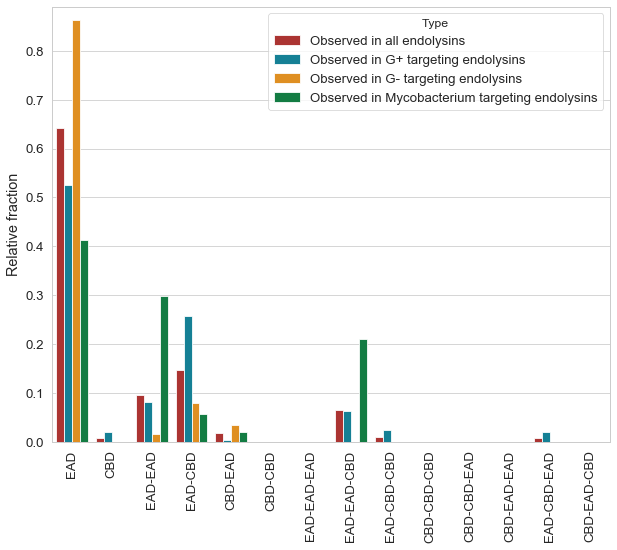

In [16]:
plt.figure(figsize=(10,8))
colors = ["#BF211E", "#008EAA", "#FF9402", "#018E42", "#00272B"]
sb.set_palette(sb.color_palette(colors))
sb.set_style("whitegrid")
sb.set_context("paper", font_scale=1.5)
g = sb.barplot(x="Arch", y = "Relative fraction", hue = "Type", data=mod_adj_df)
#g.legend_.remove()
plt.xlabel('')
plt.ylim(0, 0.89)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.savefig('barplot_all_entries.svg', format='svg')

### Examination of unannotated space

(0, 450)

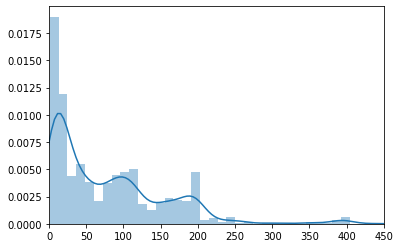

In [34]:
sb.distplot([acc2longest_unannot[i] for i in acc2longest_unannot if i in endolysins])
plt.xlim(0, 450)

In [39]:
#np.argmax([acc2longest_unannot[i] for i in acc2longest_unannot if i in endolysins])
[i for i in acc2longest_unannot if i in endolysins][1460]

'A0A142KA99'

In [28]:
### wrangle data into shape
acc2annlen = {}
acc2startstop = {}
acc2longest_unannot = {}
with open('simplified_architectures_startstop.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        if len(row) == 2:
            splitted = re.split('\(|-|\)', row[1])
            start = int(splitted[1])
            stop = int(splitted[2])
            l = stop - start
            acc2startstop[row[0]] = (start, stop)
            acc2annlen[row[0]] = l
            acc2longest_unannot[row[0]] = max(start, len(acc2seq[row[0]])-stop)

G_pos_archs = {k:v for k, v in unique_seq_tmp.items() if len(set(gpos.Genus).intersection(set(host_per_entry[k]))) > 0}
G_neg_archs = {k:v for k, v in unique_seq_tmp.items() if len(set(gneg.Genus).intersection(set(host_per_entry[k]))) > 0}
G_amb_archs = {k:v for k, v in unique_seq_tmp.items() if len(set(gamb.Genus).intersection(set(host_per_entry[k]))) > 0}

G_pos_ead_seq_lens = {k:len(acc2seq[k]) for k,v in G_pos_archs.items() if len(v) == 1 and v[0] in eads}
G_pos_ead_ann_lens = {k:acc2annlen[k] for k,v in G_pos_archs.items() if len(v) == 1 and v[0] in eads}
G_neg_ead_seq_lens = {k:len(acc2seq[k]) for k,v in G_neg_archs.items() if len(v) == 1 and v[0] in eads}
G_neg_ead_ann_lens = {k:acc2annlen[k] for k,v in G_neg_archs.items() if len(v) == 1 and v[0] in eads}
G_amb_ead_seq_lens = {k:len(acc2seq[k]) for k,v in G_amb_archs.items() if len(v) == 1 and v[0] in eads}
G_amb_ead_ann_lens = {k:acc2annlen[k] for k,v in G_amb_archs.items() if len(v) == 1 and v[0] in eads}

gpos_acc_lens_df = pd.DataFrame(index=set(G_pos_ead_seq_lens.keys()), 
                           columns=['Total length', 'Annotated length'])
for i in gpos_acc_lens_df.index:   
    if i in G_pos_ead_seq_lens:
        gpos_acc_lens_df.loc[i, 'Total length'] = G_pos_ead_seq_lens[i]
        gpos_acc_lens_df.loc[i, 'Annotated length'] = G_pos_ead_ann_lens[i]
        
gneg_acc_lens_df = pd.DataFrame(index=set(G_neg_ead_seq_lens.keys()), 
                           columns=['Total length', 'Annotated length'])
for i in gneg_acc_lens_df.index:   
    if i in G_neg_ead_seq_lens:
        gneg_acc_lens_df.loc[i, 'Total length'] = G_neg_ead_seq_lens[i]
        gneg_acc_lens_df.loc[i, 'Annotated length'] = G_neg_ead_ann_lens[i]
        
gamb_acc_lens_df = pd.DataFrame(index=set(G_amb_ead_seq_lens.keys()), 
                           columns=['Total length', 'Annotated length'])
for i in gamb_acc_lens_df.index:   
    if i in G_amb_ead_seq_lens:
        gamb_acc_lens_df.loc[i, 'Total length'] = G_amb_ead_seq_lens[i]
        gamb_acc_lens_df.loc[i, 'Annotated length'] = G_amb_ead_ann_lens[i]

In [18]:
G_pos_ann_sizes = {}
for length in np.arange(1, 570):
    tmp = [gpos_acc_lens_df.loc[i, 'Annotated length'] for i in gpos_acc_lens_df.index if gpos_acc_lens_df.loc[i, 'Total length'] == length]
    for j in set(tmp):
        G_pos_ann_sizes[(length, j)] = 0
    for j in tmp:
        G_pos_ann_sizes[(length, j)] += 1
        
G_pos_ann_sizes_df = pd.DataFrame(index=np.arange(len(G_pos_ann_sizes)), columns=['Total', 'Annotated', 'Number'])
idx = 0
for k, v in G_pos_ann_sizes.items():
    G_pos_ann_sizes_df.loc[idx, 'Total'] = k[0]
    G_pos_ann_sizes_df.loc[idx, 'Annotated'] = k[1]
    G_pos_ann_sizes_df.loc[idx, 'Number'] = v
    idx += 1

In [19]:
G_neg_ann_sizes = {}
for length in np.arange(1, 400):
    tmp = [gneg_acc_lens_df.loc[i, 'Annotated length'] for i in gneg_acc_lens_df.index if gneg_acc_lens_df.loc[i, 'Total length'] == length]
    for j in set(tmp):
        G_neg_ann_sizes[(length, j)] = 0
    for j in tmp:
        G_neg_ann_sizes[(length, j)] += 1
        
G_neg_ann_sizes_df = pd.DataFrame(index=np.arange(len(G_neg_ann_sizes)), columns=['Total', 'Annotated', 'Number'])
idx = 0
for k, v in G_neg_ann_sizes.items():
    G_neg_ann_sizes_df.loc[idx, 'Total'] = k[0]
    G_neg_ann_sizes_df.loc[idx, 'Annotated'] = k[1]
    G_neg_ann_sizes_df.loc[idx, 'Number'] = v
    idx += 1

In [20]:
G_amb_ann_sizes = {}
for length in np.arange(1, 580):
    tmp = [gamb_acc_lens_df.loc[i, 'Annotated length'] for i in gamb_acc_lens_df.index if gamb_acc_lens_df.loc[i, 'Total length'] == length]
    for j in set(tmp):
        G_amb_ann_sizes[(length, j)] = 0
    for j in tmp:
        G_amb_ann_sizes[(length, j)] += 1
        
G_amb_ann_sizes_df = pd.DataFrame(index=np.arange(len(G_amb_ann_sizes)), columns=['Total', 'Annotated', 'Number'])
idx = 0
for k, v in G_amb_ann_sizes.items():
    G_amb_ann_sizes_df.loc[idx, 'Total'] = k[0]
    G_amb_ann_sizes_df.loc[idx, 'Annotated'] = k[1]
    G_amb_ann_sizes_df.loc[idx, 'Number'] = v
    idx += 1

In [21]:
G_pos_ann_sizes_df['Gram-type'] = 'Positive'
G_neg_ann_sizes_df['Gram-type'] = 'Negative'
G_amb_ann_sizes_df['Gram-type'] = 'Mycobacteria'
ann_sizes_df = pd.concat([G_pos_ann_sizes_df, G_neg_ann_sizes_df, G_amb_ann_sizes_df])
#ann_sizes_df

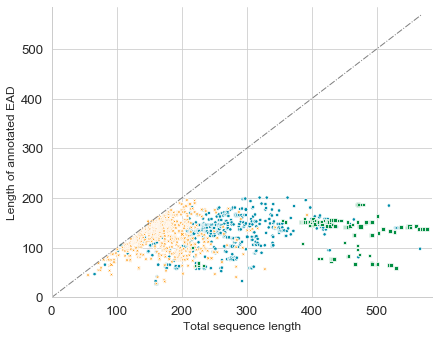

In [30]:
g = sb.relplot(x="Total", y="Annotated", size="Number", hue = 'Gram-type', style = 'Gram-type',
               data=ann_sizes_df, legend=None)
g.fig.set_size_inches(7,5)

#sb.set_style("whitegrid")
plt.xlabel('Total sequence length', fontsize=12)
plt.ylabel('Length of annotated EAD', fontsize=12)
plt.plot([0, 570], [0, 570], linestyle='-.', color='gray', linewidth=1)
plt.xlim(0, 585)
plt.ylim(0, 585)
colors = ["#008EAA", "#FF9402", "#018E42"]
sb.set_palette(sb.color_palette(colors))
plt.savefig('barplot_ead_onlies_nogrid.svg', format='svg')

In [21]:
### estimate falsely identified 'globular' proteins
reported_globulars = 0
likely_false_globulars = 0
false_Cterm = 0
false_Nterm = 0
for i in acc2startstop:
    if i in unique_seq_accs and i in endolysins:
        reported_globulars += 1
        crit = 0
        if acc2startstop[i][0] > 40:
            likely_false_globulars += 1
            false_Nterm += 1
            crit = 1
    
        if len(acc2seq[i]) - acc2startstop[i][1] > 40:
            false_Cterm += 1
            if crit == 0:
                likely_false_globulars += 1
print('Out of', reported_globulars, 'supposed globular endolysins,', likely_false_globulars, 
      'have substantially large unannotated subsequence(s) to harbor an unannotated/unknown domain.')
print(false_Cterm, 'have such subsequences C-terminally and', false_Nterm, 'have such N-terminally.')

Out of 2816 supposed globular endolysins, 1569 have substantially large unannotated subsequence(s) to harbor an unannotated/unknown domain.
1314 have such subsequences C-terminally and 737 have such N-terminally.


## Adjacency matrix for chord plots

In [27]:
### USING NON-CONDENSED ARCHS
### Load in architectures
domains_per_entry = {}
with open('simplified_architectures.csv', mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        domains_per_entry[row[0]] = [i for idx, i in enumerate(row) if idx != 0 and i != '']
endolysin_archs = {k:v for k, v in domains_per_entry.items() if k in endolysins}

### ENDOLYSINS
sorted_endo_doms = [i for i in sorted_doms if i in set(chain.from_iterable(endolysin_archs.values()))]
emp_ab_endo_adjmat = np.zeros((len(sorted_endo_doms), len(sorted_endo_doms)))
for i in endolysin_archs:
    for jdx in range(len(endolysin_archs[i])-1):
        emp_ab_endo_adjmat[sorted_endo_doms.index(endolysin_archs[i][jdx]), sorted_endo_doms.index(endolysin_archs[i][jdx+1])] += 1

emp_ab_endo_adjmat_df = pd.DataFrame(emp_ab_endo_adjmat, columns=sorted_endo_doms)
emp_ab_endo_adjmat_df.to_csv("empirical_adjmat_endolysin_abundance.csv")

In [59]:
### GH108-PG3
nextto = []
for i in endolysin_archs:
    #crit = 0
    if len(endolysin_archs[i]) == 1 and endolysin_archs[i][0] == 'GH108':
        nextto.append('')
    for j in range(len(endolysin_archs[i])-1):
        if endolysin_archs[i][j] == 'GH108':
            #if crit == 0:
            nextto.append(endolysin_archs[i][j+1])
                #crit = 1
print(np.unique(nextto, return_counts=True))
print(216/229)

(array(['', 'PG_3'], dtype='<U4'), array([ 13, 216]))
0.9432314410480349


In [61]:
### PET_M23-Ami_2
nextto = []
for i in endolysin_archs:
    #crit = 0
    if len(endolysin_archs[i]) == 1 and endolysin_archs[i][0] == 'CW_1':
        nextto.append('')
    for j in range(1, len(endolysin_archs[i])):
        if endolysin_archs[i][j] == 'CW_1':
            #if crit == 0:
            nextto.append(endolysin_archs[i][j-1])
                #crit = 1
a = np.unique(nextto, return_counts=True)
print(a)
print(a[1][3]/sum(a[1]))
print(a[1][0]/sum(a[1]))

(array(['Ami_2', 'Ami_5', 'CHAP', 'CW_1', 'GH25'], dtype='<U5'), array([103,   4,   7, 606,  10]))
0.8301369863013699
0.1410958904109589


In [44]:
### amidases
nextto = []
for i in endolysin_archs:
    for j in range(len(endolysin_archs[i])-1):
        if endolysin_archs[i][j] in amidases:
            if endolysin_archs[i][j+1] in cbds:
                nextto.append(domains_per_entry[i][j+1])
print(np.unique(nextto, return_counts=True))

(array(['CW_1', 'CW_7', 'LysM', 'PG_1', 'SH3'], dtype='<U4'), array([  7,   1,   1,   7, 100]))


In [65]:
c = 0
cbd_rep = 0
ead_rep = 0
for i in endolysin_archs:
    crit = 0
    for j in range(len(endolysin_archs[i])-1):
        if endolysin_archs[i][j] == endolysin_archs[i][j+1]:
            if crit == 0:
                c += 1
                crit = 1
                if endolysin_archs[i][j] in cbds:
                    cbd_rep += 1
                elif endolysin_archs[i][j] in eads:
                    ead_rep += 1
print(c/len(endolysin_archs))
print(c)
print(cbd_rep)
print(ead_rep)

0.05805704357897785
401
401
0


In [53]:
### CHAP
nextto = []
for i in endolysin_archs:
    for j in range(len(endolysin_archs[i])-1):
        if endolysin_archs[i][j] == 'CHAP':
            nextto.append(endolysin_archs[i][j+1])
a = np.unique(nextto, return_counts=True)
print(a[0][0], ":", a[1][0]/sum(a[1]) *100, "%")
print(a[0][1], ":", a[1][1]/sum(a[1]) *100, "%")
print(a[0][2], ":", a[1][2]/sum(a[1]) *100, "%")
print(a[0][3], ":", a[1][3]/sum(a[1]) *100, "%")
print(a[0][4], ":", a[1][4]/sum(a[1]) *100, "%")
print(a[0][5], ":", a[1][5]/sum(a[1]) *100, "%")
print(a[0][6], ":", a[1][6]/sum(a[1]) *100, "%")
print(a[0][7], ":", a[1][7]/sum(a[1]) *100, "%")
print(a[0][8], ":", a[1][8]/sum(a[1]) *100, "%")

Ami_2 : 33.64485981308411 %
Ami_3 : 4.361370716510903 %
CW_1 : 2.1806853582554515 %
CW_7 : 0.3115264797507788 %
GH25 : 19.314641744548286 %
GLUCO : 6.5420560747663545 %
LysM : 0.3115264797507788 %
PG_1 : 2.1806853582554515 %
SH3 : 31.15264797507788 %


In [ ]:
c = 0
for i in endolysin_archs:
    if set(['CHAP', 'SH3']).issubset(set(endolysin_archs[i])):
        c += 1
print(c/len(endolysin_archs))